In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
class NoteIsoSequence(keras.utils.Sequence):
    """Generate note iso data for training/validation."""
    def __init__(self, song_path, noisy, sample_duration=16000, n_fft=512, batch_size=1, shuffle=False, 
                 fs=16000, sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"):
        self.song_path = song_path
        pm = pretty_midi.PrettyMIDI(song_path)
        self.pm_samples = pm.fluidsynth(fs=fs, sf2_path=sf2_path)
#         assert np.all(self.pm_samples == samples)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.fs = fs
        self.sf2_path = sf2_path
        self.sample_duration = sample_duration
        self.n_fft = n_fft
        self.noisy = noisy
#         self.indices = np.arange(len(self.song_paths))
#         if self.shuffle == True:
#             np.random.shuffle(self.indices)
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return 1 #int(np.floor(len(self.song_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices
        #indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        #batch_song_paths = [self.song_paths[k] for k in indices]

        # Generate data
        #X, y = self.process_batch(self.song_paths[index])
        X, y = self.process_batch(self.song_path, self.pm_samples)
        
        
#         song_path = self.song_paths[index]

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
#         if self.shuffle == True:
#             np.random.shuffle(self.indices)
        pass

    def process_batch(self, song_path, samples):
        'Generates data containing batch_size samples' 
        # each batch from one instrument of one song
        # X needs to be 3 seconds of audio surrounding 
        pm = pretty_midi.PrettyMIDI(song_path)
#         num_instruments = len(pm.instruments)
        instr_id = 0 #np.random.randint(num_instruments)
#         num_notes = len(pm.instruments[instr_id].notes)
#         note_ids = np.array([0])#np.random.randint(num_notes, size=self.batch_size)
        
#         pm_samples = samples #pm.fluidsynth(fs=self.fs, sf2_path=self.sf2_path)
        
        X = []
        y = []
        note_ids = [0]
#         print(pm.instruments[0])
#         print(pm.instruments[0].notes[0])
        for note_id in note_ids:
            pm_iso = pretty_midi.PrettyMIDI()
            #print(pm.instruments[0].notes[1])
            pm_iso.instruments = [pm.instruments[0]]
            #print(pm_iso.instruments)
            note = pm_iso.instruments[0].notes[0]
            pm_iso.instruments[0].notes = [note]
#             print(pm_iso.instruments[0])
#             print(note)
            #print(pm_iso.instruments[0].notes)
            note_start = note.start
#             print("start {}".format(note_start))
            note_end = note.end
#             print("end {}".format(note_end))
            note_pitch = note.pitch
#             print("pitch {}".format(note_pitch))
            note_velocity = note.velocity
#             print("velocity {}".format(note_velocity))
            #print("velocity {}".format(note_velocity))
            note_iso_duration = note_end - note_start
            #print("duration {}s".format(note_iso_duration))
            #print(note.end)
            note.end = note_iso_duration
            #print(note.end)
#             print(int(note_start * self.fs))
            sample_start = int(note_start * self.fs)
            note.start = 0.0
            
            
#             print(int(note_start * self.fs))
            
            pm_iso_samples = pm_iso.fluidsynth(fs=self.fs, sf2_path=self.sf2_path)
            if len(pm_iso_samples) > self.sample_duration:
                pm_iso_samples = pm_iso_samples[:self.sample_duration]
            if len(pm_iso_samples) < self.sample_duration:
                pm_iso_samples = np.pad(pm_iso_samples, (0, self.sample_duration-len(pm_iso_samples)), 
                                        'constant', constant_values=(0,0))
            
            padded_samples = samples[:]
#             print("samples")
#             plt.plot(samples)
#             plt.show
#             print("padded samples")
#             print(padded_samples)
            if len(padded_samples > sample_start+self.sample_duration):
#                 print(len(padded_samples))
                padded_samples = padded_samples[sample_start:sample_start+self.sample_duration]
#                 print(len(padded_samples))
            if len(padded_samples) < self.sample_duration:
                assert False
                padded_samples = np.pad(padded_samples, (0, self.sample_duration-len(padded_samples)), 
                                        'constant', constant_values=(0,0))
#             assert np.all(self.noisy == padded_samples)
#             print("padded samples")
#             plt.plot(padded_samples)
#             plt.show
                
            assert len(padded_samples) == len(pm_iso_samples)
            noisy_stft = librosa.core.stft(y=padded_samples, n_fft=self.n_fft)
#             plt.figure(figsize=(10, 4))
#             librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
#                                      y_axis='mel', fmax=8000, x_axis='time')
#             plt.colorbar(format='%+2.0f dB')
#             plt.title('STFT')
#             plt.tight_layout()
            iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=self.n_fft)
#             print("noisy")
#             print(noisy_stft)
#             print("iso")
#             print(iso_stft)
            assert noisy_stft.shape == iso_stft.shape
#             assert self.noisy.shape == noisy_stft.shape
#             assert np.all(self.noisy == noisy_stft)
            complex_mask = np.divide(iso_stft, noisy_stft, out=np.zeros_like(iso_stft), where=noisy_stft!=0)
            
            # convert complex numbers to real and imaginary parts
            final_mask = np.append(complex_mask.real, complex_mask.imag, axis=0)
            final_noisy = np.append(noisy_stft.real, noisy_stft.imag, axis=0)
            
#             annotation = np.zeros((final_noisy.shape[0], 1))
#             annotation[0] = note_pitch
#             annotation[1] = note_velocity
#             annotation[2] = note_start
#             annotation[3] = note_end
#             annotation[4] = note_start - note_end
#             input_x = np.append(final_noisy, annotation, axis=1)
            for j in range(32):
                X.append(final_noisy)
                y.append(final_mask)
#             print("final noisy")
#             print(final_noisy)
#             print("final mask")
#             print(final_mask)
        X = np.array(X)
        y = np.array(y)

        return X, y

In [3]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)
# midi_files = [midi_file for midi_file in midi_files]
# num_files = len(midi_files)

# train_files = midi_files[0:1] #midi_files[int(num_files/5):]
# valid_files = midi_files[0:1] #midi_files[:int(num_files/5)]

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [4]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 16000
sample_duration = 50
n_fft = 8
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
print('hi')

hi


In [5]:
# ipd.Audio(data=pm_samples, rate=44100)

In [6]:
pm_iso = pretty_midi.PrettyMIDI()
print(pm.instruments[0].notes[0])
pm_iso.instruments = [pm.instruments[0]]
print(pm_iso.instruments)
note = pm_iso.instruments[0].notes[0]
pm_iso.instruments[0].notes = [note]
print(pm_iso.instruments[0].notes)
note_start = note.start
note_end = note.end
note_pitch = note.pitch
note_velocity = note.velocity
print("velocity {}".format(note_velocity))
note_iso_duration = note_end - note_start
print("duration {}s".format(note_iso_duration))
print(note.end)
note.end = note_iso_duration
note.start = 0.0

sample_start = int(note_start * sample_rate)
sample_end = sample_start + sample_duration

Note(start=51.199077, end=51.318123, pitch=81, velocity=105)
[Instrument(program=0, is_drum=False, name="A.PIANO 1")]
[Note(start=51.199077, end=51.318123, pitch=81, velocity=105)]
velocity 105
duration 0.11904583333333107s
51.318123125


In [7]:
pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                                'constant', constant_values=(0,0))
ipd.Audio(pm_iso_samples, rate=sample_rate)

In [8]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(5021885,)


In [9]:
print(padded_samples.shape)
print(pm_iso_samples.shape)
print(padded_samples[-1])
print(pm_iso_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(50,)
(50,)
0.16506433959473452
0.016097875080489377


(5, 26)


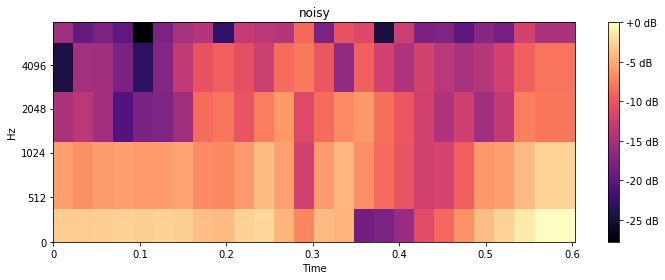

In [10]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()

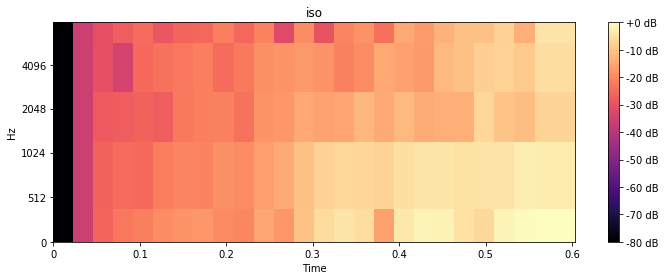

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

130
5
125
5
125
5
0


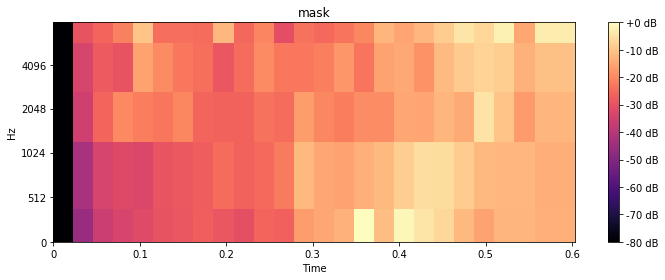

In [12]:
mask = iso_stft / noisy_stft
assert np.all(iso_stft != noisy_stft)
print(np.count_nonzero(noisy_stft))
print(len(noisy_stft))
print(np.count_nonzero(iso_stft))
print(len(iso_stft))
print(np.count_nonzero(mask))
print(len(mask))
print(np.count_nonzero(np.isnan(mask)))
#np.count_nonzero(noisy_stft) == len(noisy_stft)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(mask), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('mask')
plt.tight_layout()

(6.4061565-0j)
(-8.302157-0j)


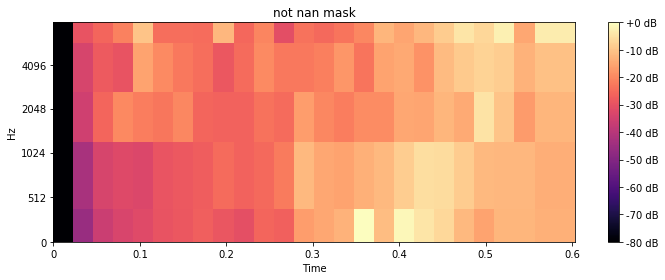

In [13]:
complex_mask = np.divide(iso_stft, noisy_stft, out=np.zeros_like(iso_stft), where=noisy_stft!=0)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(complex_mask), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('not nan mask')
plt.tight_layout()
print(np.max(complex_mask))
print(np.min(complex_mask))

In [14]:
train_generator = NoteIsoSequence(midi_file, padded_samples, sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft)
valid_generator = NoteIsoSequence(midi_file, padded_samples, sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft)

rows = 10
cols = 26
model = keras.models.Sequential()
model.add(keras.layers.Reshape((rows*cols,), input_shape=(rows, cols)))
model.add(keras.layers.Dense(300))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(rows*cols))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(400))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(300))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(rows*cols))
model.add(keras.layers.Reshape((rows, cols)))
# model.add(keras.layers.Dense(400))
# model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.Dense(1*1*128))
# model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.Reshape((1, 1, 128)))
# model.add(keras.layers.BatchNormalization(momentum=0.8))
# model.add(keras.layers.UpSampling2D(size=(2, 1)))
# model.add(keras.layers.Conv2D(64, 3, padding="same"))
# model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.BatchNormalization(momentum=0.8))
# model.add(keras.layers.UpSampling2D(size=(5, 13)))
# model.add(keras.layers.Conv2D(16, 3, padding="same"))
# model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.Conv2D(2, 3, padding="same"))
# model.add(keras.layers.Activation("sigmoid"))
model.add(keras.layers.Reshape((rows, cols)))
    
sgd = keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=sgd, loss='mean_squared_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 260)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               78300     
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 260)               78260     
_________________________________________________________________
activation_2 (Activation)    (None, 260)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               104400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
__________

In [15]:
model.fit_generator(generator=train_generator,
                    validation_data=train_generator,
                    use_multiprocessing=True,
                    workers=6, steps_per_epoch=100, epochs=10,
                    validation_steps=1)

Epoch 1/10
100/100 [==============================] - 91s 909ms/step - loss: 0.2967 - val_loss: 1.0415e-05
Epoch 2/10
100/100 [==============================] - 91s 906ms/step - loss: 6.8164e-07 - val_loss: 1.6668e-12
Epoch 3/10
Epoch 2/10
100/100 [==============================] - 91s 905ms/step - loss: 3.5798e-13 - val_loss: 9.2217e-14
Epoch 4/10
100/100 [==============================] - 91s 907ms/step - loss: 5.9768e-14 - val_loss: 3.6610e-14
Epoch 5/10
100/100 [==============================] - 90s 905ms/step - loss: 2.7557e-14 - val_loss: 2.1663e-14
Epoch 6/10
100/100 [==============================] - 90s 902ms/step - loss: 1.9813e-14 - val_loss: 1.4358e-14
Epoch 7/10
100/100 [==============================] - 91s 905ms/step - loss: 1.3108e-14 - val_loss: 1.1409e-14
Epoch 8/10
100/100 [==============================] - 90s 903ms/step - loss: 1.0676e-14 - val_loss: 1.0240e-14
Epoch 9/10
100/100 [==============================] - 90s 903ms/step - loss: 9.4307e-15 - val_loss: 7.983

In [16]:
#model.save('test_model.h5')

In [17]:
test_loss = model.evaluate_generator(train_generator, steps=1)

In [18]:
print(test_loss)

7.559799547430732e-15


In [19]:
predicted = model.predict_generator(train_generator, steps=1)
print(predicted.shape)
predicted = predicted[0]
print(predicted.shape)
predicted_real = predicted[:int(rows/2)]
predicted_imag = predicted[int(rows/2):]
predicted_stft = predicted_real + 1j * predicted_imag
print(predicted_stft[0][0])
print(predicted_stft[0][1])
print(predicted_stft[0][2])
print(predicted_stft[1][0])
print(predicted_stft[2][0])
print(predicted_stft[3][0])
print(predicted_stft[1][1])
print(predicted_stft[2][1])
print(predicted_stft[3][1])
print(predicted_stft.shape)

(32, 10, 26)
(10, 26)
(-3.236346e-08+1.5320256e-07j)
(-0.00021134643-9.2200935e-08j)
(-0.0020958092-1.4458783e-07j)
(6.9790985e-08-6.193295e-08j)
(3.3993274e-08-1.5320256e-07j)
(-1.2572855e-08-4.004687e-08j)
(0.00033855066+0.00031723862j)
(-0.00088000577+0.0022973958j)
(0.0035281763-0.0005185746j)
(5, 26)


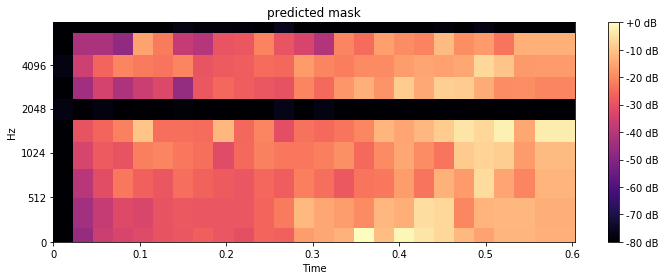

In [20]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(predicted), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted mask')
plt.tight_layout()

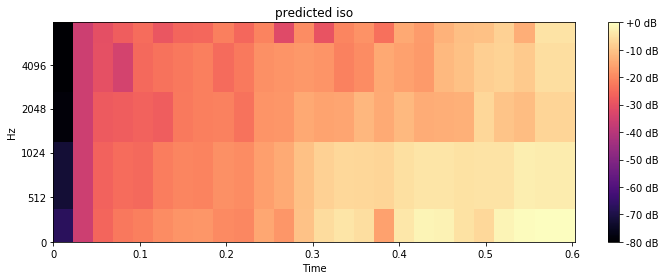

In [21]:
predicted_iso = noisy_stft * predicted_stft
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(predicted_iso), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted iso')
plt.tight_layout()

In [22]:
iso_audio = librosa.core.istft(predicted_iso)
print(len(iso_audio))
ipd.Audio(iso_audio, rate=sample_rate)

50


<function matplotlib.pyplot.show(*args, **kw)>

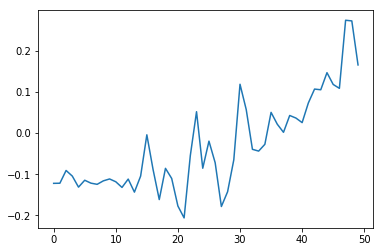

In [23]:
plt.plot(padded_samples)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

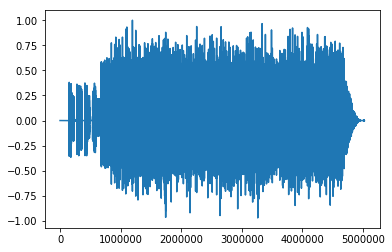

In [24]:
plt.plot(pm_samples)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

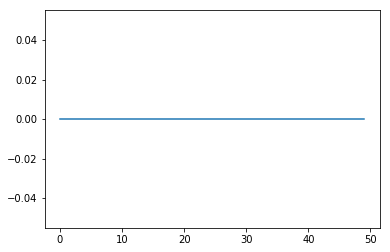

In [25]:
plt.plot(pm_samples[:50])
plt.show